*italicized text*# MNIST Digit Interpolation
 Steps
 

1.   Train auto-encoder recreate pictures of digits from MNIST dataset
2.   Interpolate any two elements of MNIST with learned embeddings



# Initializing and training model

In [15]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import os

from matplotlib import pyplot as plt
from constants import REPO_DIR
from utils import get_saved_model, NormalizeImage

In [25]:
class PrintModule(nn.Module):
  def __init__(self, message):
    super().__init__()
    self.message = message

  def forward(self, x):
    print(self.message)
    return x

class AutoEncoder(nn.Module):

  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=2, padding=1),
        nn.ReLU(True),
        nn.Conv2d(8, 16, 3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.Conv2d(16, 32, 3, stride=2, padding=0),
        nn.ReLU(True),
        nn.Flatten(start_dim=1),
        nn.Linear(3 * 3 * 32, 128),
        nn.ReLU(True),
        nn.Linear(128, 16),
    )

    self.decoder = nn.Sequential(
        nn.Linear(16, 128),
        nn.ReLU(True),
        nn.Linear(128, 3 * 3 * 32),
        nn.ReLU(True),
        nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3)),
        nn.ConvTranspose2d(32, 16, 3, 
        stride=2, output_padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride=2, 
        padding=1, output_padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride=2, 
        padding=1, output_padding=1)
    )
  def forward(self, x):
    z = self.encoder(x)
    x = self.decoder(z)
    return torch.sigmoid(x)


In [17]:
def retrain_model():
    """
    @returns: retrains new model
    """
    transform = transforms.Compose([transforms.ToTensor(), NormalizeImage()])
    training_set = tv.datasets.MNIST(root = './data', train = True, download = True, transform=transform)
    dataloader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=False)

    num_epochs = 5
    batch_size = 32
    model = AutoEncoder().cpu()
    distance = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

    for epoch in range(num_epochs):
        for data in dataloader:
            #note, img from dataloader has dimensions 32x28x28 (batch size is 32)
            #Conv2d input shape is 32x1x28x28 (batch_size x num_channels x width x height)
            img, _ = data
            img = img.reshape(batch_size, -1, 28, 28)
            img = torch.autograd.Variable(img).cpu()
            # ===================forward=====================
            output = model(img)
            loss = distance(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    return model.eval()
    

In [18]:
AUTOENCODER_DEFAULT_WEIGHT_PATH = os.path.join(REPO_DIR, 'architectures', 'weights', 'autoencoder_state_dict.pt')

def save_model(model, weight_path=AUTOENCODER_DEFAULT_WEIGHT_PATH):
    """
    @param model: model to save
    @param weight_path: path to save weights to
    """
    if not os.path.isfile(weight_path):
        os.makedirs(os.path.dirname(weight_path), exist_ok = True)
    torch.save(model.state_dict(), weight_path)


def load_saved_model(weight_path=AUTOENCODER_DEFAULT_WEIGHT_PATH):
    """
    @param weight_path: points to path where weights are stored to load model
    @returns: Trained model
    @throws: Exception if no weights stored at weight_path
    """
    return get_saved_model(AutoEncoder, weight_path)

In [19]:
model_2 = load_saved_model()

# Viewing results

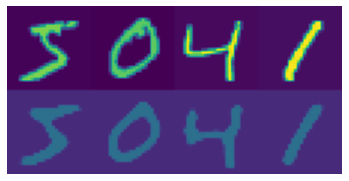

In [24]:
from utils import show_examples

show_examples(model_2, 4)

# Interpolation

In [21]:
from utils import get_img, display_interpolation_by_img, display_interpolation_by_idx

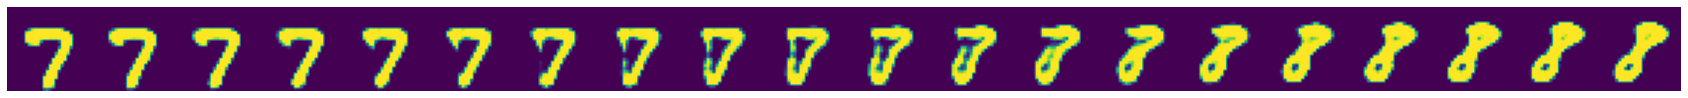

In [23]:
display_interpolation_by_idx(model_2, 52, 31, 20)